# tests

In [1]:
import sys
import os
import time
import cupy as cp
import numpy as np
import mrcfile
import healpy as hp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.fftpack import fft2, ifft2
from skimage import filters, feature, transform

def read_mrc_file(file_path):
    """Reads a volume from an MRC file."""
    if not os.path.isfile(file_path):
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)
    try:
        with mrcfile.open(file_path, permissive=True) as mrc:
            volume = mrc.data.astype(cp.float32)
            voxel_size = mrc.voxel_size
            if volume.ndim != 3:
                print("Error: Input volume is not 3-dimensional.")
                sys.exit(1)
    except Exception as e:
        print(f"Error reading MRC file: {e}")
        sys.exit(1)
    return volume, voxel_size

import cupy as cp

def rotate_and_project(volume, phi, theta, psi):
    """Rotates the volume and projects it along the Z-axis using CUDA."""
    # Ensure volume is a CuPy array
    volume_gpu = cp.asarray(volume, dtype=cp.float32)

    # Convert angles to CuPy-compatible scalars
    phi = cp.array(phi, dtype=cp.float32)
    theta = cp.array(theta, dtype=cp.float32)
    psi = cp.array(psi, dtype=cp.float32)

    # Dimensions of the volume
    dims = volume_gpu.shape
    center = cp.array([dims[0] // 2, dims[1] // 2, dims[2] // 2], dtype=cp.float32)

    # Rotation matrices
    rotation_y = cp.array([[cp.cos(cp.radians(theta)), 0, cp.sin(cp.radians(theta))],
                           [0, 1, 0],
                           [-cp.sin(cp.radians(theta)), 0, cp.cos(cp.radians(theta))]], dtype=cp.float32)

    rotation_z_phi = cp.array([[cp.cos(cp.radians(phi)), -cp.sin(cp.radians(phi)), 0],
                               [cp.sin(cp.radians(phi)), cp.cos(cp.radians(phi)), 0],
                               [0, 0, 1]], dtype=cp.float32)

    rotation_z_psi = cp.array([[cp.cos(cp.radians(psi)), -cp.sin(cp.radians(psi)), 0],
                               [cp.sin(cp.radians(psi)), cp.cos(cp.radians(psi)), 0],
                               [0, 0, 1]], dtype=cp.float32)

    # Combined rotation matrix
    rotation_matrix = rotation_z_psi @ rotation_z_phi @ rotation_y

    # Generate grid of coordinates
    x, y, z = cp.meshgrid(cp.arange(dims[0]), cp.arange(dims[1]), cp.arange(dims[2]), indexing='ij')
    coords = cp.stack([x.ravel(), y.ravel(), z.ravel()], axis=0).astype(cp.float32)

    # Center coordinates
    coords_centered = coords - center[:, None]

    # Apply rotation
    rotated_coords = rotation_matrix @ coords_centered

    # Shift back to original center
    rotated_coords += center[:, None]

    # Interpolation for rotation
    rotated_volume = cp.zeros_like(volume_gpu)
    for i in range(rotated_coords.shape[1]):
        x, y, z = rotated_coords[:, i]
        if (0 <= x < dims[0]) and (0 <= y < dims[1]) and (0 <= z < dims[2]):
            rotated_volume[int(x), int(y), int(z)] = volume_gpu[int(coords[0, i]), int(coords[1, i]), int(coords[2, i])]

    # Project along Z-axis
    projection_gpu = cp.sum(rotated_volume, axis=2)

    return projection_gpu  # Convert back to NumPy for compatibility


# Example usage
volume_file = '0_data/7ood.mrc'
volume, voxel_size = read_mrc_file(volume_file)
phi, theta, psi = 45, 30, 60
projection = rotate_and_project(volume, phi, theta, psi)
print(projection)

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

Projection shape: (128, 128)


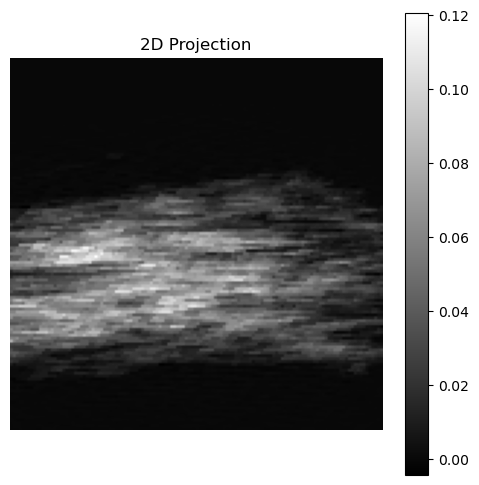

In [11]:
import numpy as np
from numba import cuda, float32
import math
import mrcfile

def read_mrc_file(file_path):
    """Reads a volume from an MRC file."""
    if not os.path.isfile(file_path):
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)
    try:
        with mrcfile.open(file_path, permissive=True) as mrc:
            volume = mrc.data.astype(cp.float32)
            voxel_size = mrc.voxel_size
            if volume.ndim != 3:
                print("Error: Input volume is not 3-dimensional.")
                sys.exit(1)
    except Exception as e:
        print(f"Error reading MRC file: {e}")
        sys.exit(1)
    return volume, voxel_size

@cuda.jit
def volume_projection_kernel(volume, projection, sin_psi, cos_psi, sin_theta, cos_theta, sin_phi, cos_phi):
    """
    CUDA kernel to compute the projection of a volume along the rotated z-axis.
    """
    x, y = cuda.grid(2)  # Get the thread indices for the projection
    nx, ny, nz = volume.shape

    if x < nx and y < ny:
        sum_projection = 0.0
        for z in range(nz):
            # Transform the coordinates using rotation matrices
            rotated_x = (cos_theta * cos_psi) * x + (cos_theta * sin_psi) * y - sin_theta * z
            rotated_y = (-sin_phi * sin_theta * cos_psi + cos_phi * sin_psi) * x + \
                        (-sin_phi * sin_theta * sin_psi - cos_phi * cos_psi) * y + sin_phi * cos_theta * z
            rotated_z = (cos_phi * sin_theta * cos_psi + sin_phi * sin_psi) * x + \
                        (cos_phi * sin_theta * sin_psi - sin_phi * cos_psi) * y + cos_phi * cos_theta * z

            # Interpolation (nearest neighbor for simplicity)
            ix, iy, iz = int(round(rotated_x)), int(round(rotated_y)), int(round(rotated_z))
            if 0 <= ix < nx and 0 <= iy < ny and 0 <= iz < nz:
                sum_projection += volume[ix, iy, iz]

        projection[x, y] = sum_projection


def compute_projection(volume, psi, theta, phi):
    """
    Rotates a volume and computes its projection along the z-axis.
    
    Args:
        volume (np.ndarray): 3D input volume of shape (nx, ny, nz).
        psi (float): Rotation angle around z-axis (in radians).
        theta (float): Rotation angle around y-axis (in radians).
        phi (float): Rotation angle around x-axis (in radians).
    
    Returns:
        np.ndarray: 2D projection of the rotated volume.
    """
    # Get volume dimensions
    nx, ny, nz = volume.shape

    # Allocate device memory
    d_volume = cuda.to_device(volume)
    d_projection = cuda.device_array((nx, ny), dtype=np.float32)

    # Precompute trigonometric values
    sin_psi, cos_psi = math.sin(psi), math.cos(psi)
    sin_theta, cos_theta = math.sin(theta), math.cos(theta)
    sin_phi, cos_phi = math.sin(phi), math.cos(phi)

    # Launch CUDA kernel
    threads_per_block = (4, 4)
    blocks_per_grid_x = math.ceil(nx / threads_per_block[0])
    blocks_per_grid_y = math.ceil(ny / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    volume_projection_kernel[blocks_per_grid, threads_per_block](
        d_volume, d_projection, sin_psi, cos_psi, sin_theta, cos_theta, sin_phi, cos_phi
    )

    # Copy result back to host
    projection = d_projection.copy_to_host()
    return projection


# Example usage
volume_file = '0_data/7ood.mrc'
volume, voxel_size = read_mrc_file(volume_file)
phi, theta, psi = 45, 30, 60

# Define angles in radians
psi = np.radians(45)
theta = np.radians(30)
phi = np.radians(60)

# Compute projection
projection = compute_projection(volume, psi, theta, phi)
print("Projection shape:", projection.shape)
plt.figure(figsize=(6, 6))
plt.imshow(projection, cmap='gray')
plt.title('2D Projection')
plt.axis('off')
plt.colorbar()
plt.show()

## Trilinear interpolation

/scratch/rd_tm/7_Software/miniconda3/envs/py2DTM/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Projection shape: (128, 128)


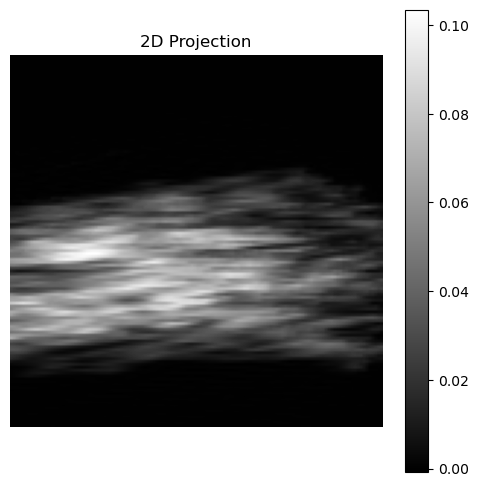

In [12]:
import numpy as np
from numba import cuda, float32
import math

@cuda.jit
def volume_projection_kernel(volume, projection, sin_psi, cos_psi, sin_theta, cos_theta, sin_phi, cos_phi):
    """
    CUDA kernel to compute the projection of a volume along the rotated z-axis using trilinear interpolation.
    """
    x, y = cuda.grid(2)  # Get the thread indices for the projection
    nx, ny, nz = volume.shape

    if x < nx and y < ny:
        sum_projection = 0.0
        for z in range(nz):
            # Transform the coordinates using rotation matrices
            rotated_x = (cos_theta * cos_psi) * x + (cos_theta * sin_psi) * y - sin_theta * z
            rotated_y = (-sin_phi * sin_theta * cos_psi + cos_phi * sin_psi) * x + \
                        (-sin_phi * sin_theta * sin_psi - cos_phi * cos_psi) * y + sin_phi * cos_theta * z
            rotated_z = (cos_phi * sin_theta * cos_psi + sin_phi * sin_psi) * x + \
                        (cos_phi * sin_theta * sin_psi - sin_phi * cos_psi) * y + cos_phi * cos_theta * z

            # Trilinear interpolation
            ix0, iy0, iz0 = int(math.floor(rotated_x)), int(math.floor(rotated_y)), int(math.floor(rotated_z))
            ix1, iy1, iz1 = ix0 + 1, iy0 + 1, iz0 + 1

            dx, dy, dz = rotated_x - ix0, rotated_y - iy0, rotated_z - iz0

            if 0 <= ix0 < nx and 0 <= iy0 < ny and 0 <= iz0 < nz:
                c000 = volume[ix0, iy0, iz0]
                c100 = volume[ix1, iy0, iz0] if ix1 < nx else 0
                c010 = volume[ix0, iy1, iz0] if iy1 < ny else 0
                c001 = volume[ix0, iy0, iz1] if iz1 < nz else 0
                c101 = volume[ix1, iy0, iz1] if ix1 < nx and iz1 < nz else 0
                c011 = volume[ix0, iy1, iz1] if iy1 < ny and iz1 < nz else 0
                c110 = volume[ix1, iy1, iz0] if ix1 < nx and iy1 < ny else 0
                c111 = volume[ix1, iy1, iz1] if ix1 < nx and iy1 < ny and iz1 < nz else 0

                # Interpolation weights
                c00 = c000 * (1 - dx) + c100 * dx
                c01 = c001 * (1 - dx) + c101 * dx
                c10 = c010 * (1 - dx) + c110 * dx
                c11 = c011 * (1 - dx) + c111 * dx

                c0 = c00 * (1 - dy) + c10 * dy
                c1 = c01 * (1 - dy) + c11 * dy

                interpolated_value = c0 * (1 - dz) + c1 * dz
                sum_projection += interpolated_value

        projection[x, y] = sum_projection


def compute_projection(volume, psi, theta, phi):
    """
    Rotates a volume and computes its projection along the z-axis using trilinear interpolation.
    
    Args:
        volume (np.ndarray): 3D input volume of shape (nx, ny, nz).
        psi (float): Rotation angle around z-axis (in radians).
        theta (float): Rotation angle around y-axis (in radians).
        phi (float): Rotation angle around x-axis (in radians).
    
    Returns:
        np.ndarray: 2D projection of the rotated volume.
    """
    # Get volume dimensions
    nx, ny, nz = volume.shape

    # Allocate device memory
    d_volume = cuda.to_device(volume)
    d_projection = cuda.device_array((nx, ny), dtype=np.float32)

    # Precompute trigonometric values
    sin_psi, cos_psi = math.sin(psi), math.cos(psi)
    sin_theta, cos_theta = math.sin(theta), math.cos(theta)
    sin_phi, cos_phi = math.sin(phi), math.cos(phi)

    # Launch CUDA kernel
    threads_per_block = (16, 16)
    blocks_per_grid_x = math.ceil(nx / threads_per_block[0])
    blocks_per_grid_y = math.ceil(ny / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    volume_projection_kernel[blocks_per_grid, threads_per_block](
        d_volume, d_projection, sin_psi, cos_psi, sin_theta, cos_theta, sin_phi, cos_phi
    )

    # Copy result back to host
    projection = d_projection.copy_to_host()
    return projection


# Example usage
volume_file = '0_data/7ood.mrc'
volume, voxel_size = read_mrc_file(volume_file)
phi, theta, psi = 45, 30, 60

# Define angles in radians
psi = np.radians(45)
theta = np.radians(30)
phi = np.radians(60)

# Compute projection
projection = compute_projection(volume, psi, theta, phi)
print("Projection shape:", projection.shape)
plt.figure(figsize=(6, 6))
plt.imshow(projection, cmap='gray')
plt.title('2D Projection')
plt.axis('off')
plt.colorbar()
plt.show()


Projection shape: (128, 128)


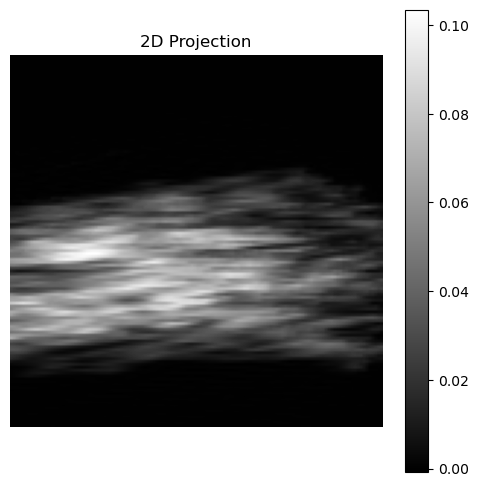

In [13]:
@cuda.jit
def volume_projection_kernel_refined(volume, projection, sin_psi, cos_psi, sin_theta, cos_theta, sin_phi, cos_phi):
    """
    CUDA kernel to compute the projection of a volume using refined trilinear interpolation.
    """
    x, y = cuda.grid(2)
    nx, ny, nz = volume.shape

    if x < nx and y < ny:
        sum_projection = 0.0
        for z in range(nz):
            # Transform the coordinates using rotation matrices
            rotated_x = (cos_theta * cos_psi) * x + (cos_theta * sin_psi) * y - sin_theta * z
            rotated_y = (-sin_phi * sin_theta * cos_psi + cos_phi * sin_psi) * x + \
                        (-sin_phi * sin_theta * sin_psi - cos_phi * cos_psi) * y + sin_phi * cos_theta * z
            rotated_z = (cos_phi * sin_theta * cos_psi + sin_phi * sin_psi) * x + \
                        (cos_phi * sin_theta * sin_psi - sin_phi * cos_psi) * y + cos_phi * cos_theta * z

            # Check bounds before interpolation
            if 0 <= rotated_x < nx - 1 and 0 <= rotated_y < ny - 1 and 0 <= rotated_z < nz - 1:
                ix0, iy0, iz0 = int(math.floor(rotated_x)), int(math.floor(rotated_y)), int(math.floor(rotated_z))
                dx, dy, dz = rotated_x - ix0, rotated_y - iy0, rotated_z - iz0

                # Trilinear interpolation
                c000 = volume[ix0, iy0, iz0]
                c100 = volume[ix0 + 1, iy0, iz0]
                c010 = volume[ix0, iy0 + 1, iz0]
                c001 = volume[ix0, iy0, iz0 + 1]
                c101 = volume[ix0 + 1, iy0, iz0 + 1]
                c011 = volume[ix0, iy0 + 1, iz0 + 1]
                c110 = volume[ix0 + 1, iy0 + 1, iz0]
                c111 = volume[ix0 + 1, iy0 + 1, iz0 + 1]

                # Interpolation weights
                c00 = c000 * (1 - dx) + c100 * dx
                c01 = c001 * (1 - dx) + c101 * dx
                c10 = c010 * (1 - dx) + c110 * dx
                c11 = c011 * (1 - dx) + c111 * dx

                c0 = c00 * (1 - dy) + c10 * dy
                c1 = c01 * (1 - dy) + c11 * dy

                interpolated_value = c0 * (1 - dz) + c1 * dz
                sum_projection += interpolated_value

        projection[x, y] = sum_projection


def compute_projection_refined(volume, psi, theta, phi):
    """
    Computes the projection with improved precision and smoothing.
    """
    nx, ny, nz = volume.shape
    d_volume = cuda.to_device(volume)
    d_projection = cuda.device_array((nx, ny), dtype=np.float32)

    sin_psi, cos_psi = math.sin(psi), math.cos(psi)
    sin_theta, cos_theta = math.sin(theta), math.cos(theta)
    sin_phi, cos_phi = math.sin(phi), math.cos(phi)

    threads_per_block = (16, 16)
    blocks_per_grid_x = math.ceil(nx / threads_per_block[0])
    blocks_per_grid_y = math.ceil(ny / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    volume_projection_kernel_refined[blocks_per_grid, threads_per_block](
        d_volume, d_projection, sin_psi, cos_psi, sin_theta, cos_theta, sin_phi, cos_phi
    )

    projection = d_projection.copy_to_host()

    # Optional: Smooth the projection to reduce noise
    from scipy.ndimage import gaussian_filter
    projection = gaussian_filter(projection, sigma=1)

    return projection


# Example usage
volume_file = '0_data/7ood.mrc'
volume, voxel_size = read_mrc_file(volume_file)
phi, theta, psi = 45, 30, 60

# Define angles in radians
psi = np.radians(45)
theta = np.radians(30)
phi = np.radians(60)

# Compute projection
projection = compute_projection(volume, psi, theta, phi)
print("Projection shape:", projection.shape)
plt.figure(figsize=(6, 6))
plt.imshow(projection, cmap='gray')
plt.title('2D Projection')
plt.axis('off')
plt.colorbar()
plt.show()